# 1. Introduction
This notebook explores how to model risk metrics like value-at-risk (VaR) and expected shortfall (ES) of a stock using a number of methods The obatined metrices are backtested using standard tests. It also checks how VaR and ES changes under stressed market conditions. Special attention is paid to volatility clustering, and how to employ MC model using time-varying volatility. 

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
import numba as nb

from scipy.stats import jarque_bera, genpareto, chi2, norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
try:
    from _plotstyle import *
except:
    None

# 2. EDA: Analysis of the closing prices

In [2]:
myTicker = 'SPY' #use SPY ETF   

In [3]:
df = yf.download(myTicker, start="2015-01-01", end="2016-12-31")
#create a table for returns and drop na
df['returns'] = df['Close'].pct_change()
df = df.dropna()
print(df.head())

/tmp/ipykernel_3103875/4200182919.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(myTicker, start="2015-01-01", end="2016-12-31")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2015-01-05  167.508789  169.709351  167.201544  169.543273  169632600   
2015-01-06  165.931061  168.339223  165.133869  167.816066  209151400   
2015-01-07  167.998734  168.339202  166.811264  167.259676  125346700   
2015-01-08  170.979889  171.195802  169.393830  169.410429  147217800   
2015-01-09  169.609726  171.411698  168.995223  171.395086  158567300   

Price        returns  
Ticker                
Date                  
2015-01-05 -0.018060  
2015-01-06 -0.009419  
2015-01-07  0.012461  
2015-01-08  0.017745  
2015-01-09 -0.008014  


Text(0.5, 1.0, 'Histogram')

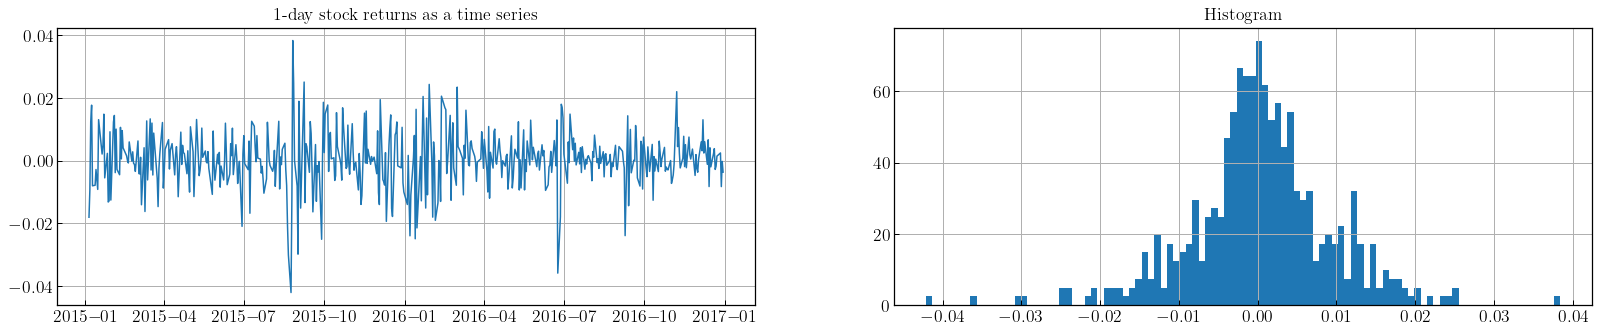

In [4]:
f,axs = plt.subplots(1,2, figsize=(22,4))
axs[0].plot(df['returns'])
axs[0].set_title("1-day stock returns as a time series")

axs[1].hist(df['returns'], bins=100, density=True)
axs[1].set_title("Histogram")

## 2.1 Normality of return prices: Jarque–Bera test

We first check if the returns are normal, which is one of the primary assumptions of Black-Scholes model. For this, we use the Jarque-Bera test with
* $H_0:$ returns are normal
* $H_1:$ returns have kurtosis, and not normal

We reject $H_0$ if p-value < 0.05.

In [5]:
JB_stat, p_value = jarque_bera(df['returns'])

print("JB statistic:", JB_stat)
print("p-value:", p_value)

JB statistic: 115.79841717433321
p-value: 7.156376880893909e-26


```Interpretation:``` p-value<0.05 suggests, the normality hypothese is rejected

* This enourages us to use fat tailed distributions like t-dist or generalized Pareto for MC simulation

## 2.2 Stationary check: Dickey-Fuller test

Another important check is whether the returns are stationary or not. This is crucial for choosing the right voltality or pricing models.

* The returns $X_t$ are (weakly) stationary if (i) $E[X_t]=\mu$ and (ii) $Cov[X_{t+h},X_t]=\gamma_h$

* We use the Dickey-Fuller test with $H_0:$ the returns are non-stationary

In [6]:
result = adfuller(df['returns'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -22.476498192682055
p-value: 0.0


```Interpretation:``` p-value<0.05 suggests that the stationary hypothese is rejected. This indicates that mean and variance can change over time.

# 3. Estimation of VaR and ES

Using various methods, we compute two popular metrics to quantify the risk: ```value-at-risk (VaR)``` and ```expected shortfall (ES)```. 

* Given a confidence level and time horizon, ```VaR``` indicates the maximum loss one can have. Here, confidence level can be 95% or 99%, where the time horizon can be daily, monthly, and so on.

* Once the loss excedes VaR threshold, an important question is: "How bad are the losses on average?". This is answered by ```Expected Shortfall (ES)``` or conditional VaR (cVaR). ES is more crucial than VaR since it gives an idea of tail risks or extreme events. This is why Basel III framework uses ES for market risk. Formally,
$$ 
\textrm{ES}_\alpha = \mathbb{E}[\textrm{Loss}|\textrm{Loss}\geq \textrm{VaR}_\alpha].
$$

Below we explore different ways to model the risk metrics

## 3.1 Parametric or Var-Covariance method
* The simplest case is when returns are normally distributed. Then we know Var $_\alpha = z_\alpha \sigma\sqrt{T}$, where $z_\alpha$ is the standard normal quantile $z_\alpha$, $\sigma$ refers to volatility, and $T$ is the time horizon.

* `Limitation:` The biggest limitation is that returns are assumed to be normal, which is not the case in realistic markets.

1-day 95% Parametric VaR (last): 1.48%
1-day 95% Parametric ES (last): 1.86%


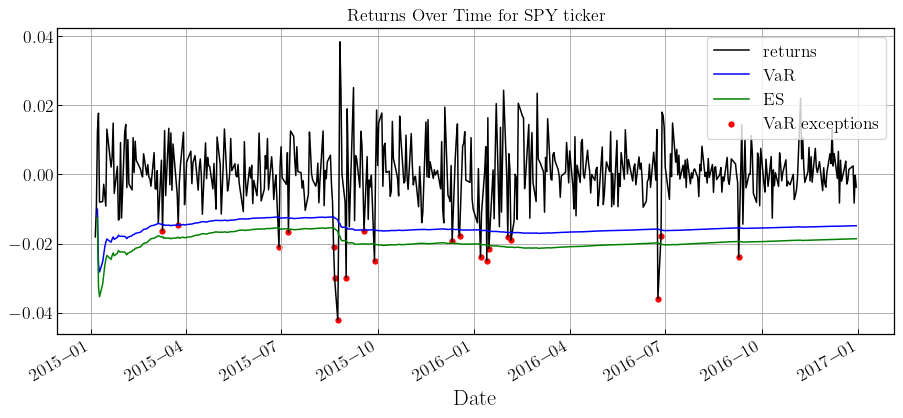

In [7]:
def get_metric_parametric(pdReturns, alpha=0.95, verbose=False):
    """
    Compute Parametric (Normal) Value at Risk (VaR) and Expected Shortfall (ES) using an expanding window.

    Parameters
    ----------
    pdReturns : pd.Series
        Series of asset returns.
    alpha : float, optional
        Confidence level for VaR/ES calculation (default is 0.95 for 95% confidence).
    verbose : bool, optional
        If True, print the last VaR and ES values (default is False).

    Returns
    -------
    VaR : np.ndarray
        Array of parametric VaR values. Initial value is NaN until at least one observation exists.
    ES : np.ndarray
        Array of parametric Expected Shortfall values. Initial value is NaN until at least one observation exists.

    """
    returns = pdReturns.values
    n = len(returns)
    z_alpha = norm.ppf(1 - alpha)  # standard normal quantile
    VaR = np.full(n, np.nan)
    ES = np.full(n, np.nan)
    for t in range(2, n):
        past_returns = returns[:t]
        sigma = past_returns.std(ddof=1)
        VaR[t] = z_alpha* sigma
        ES[t] = -sigma * norm.pdf(z_alpha) / (1 - alpha)

    if verbose:
        print(f"1-day {int(alpha*100)}% Parametric VaR (last): {-VaR[-1]:.2%}")
        print(f"1-day {int(alpha*100)}% Parametric ES (last): {-ES[-1]:.2%}")

    return VaR, ES


df['var_param'], df['es_param'] = get_metric_parametric(df['returns'], verbose=True)
df['returns'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', figsize=(12, 5))
df['var_param'].plot(label='VaR', c='b')
df['es_param'].plot(label='ES', c='g')
mask = df['returns'] < df['var_param']
plt.scatter(df.index[mask], df['returns'][mask], c='r', label='VaR exceptions')
plt.legend()

Note that, 

* We use negative of VaR, since we want to report a positive loss
* Also, last day VaR and ES is reported since they are essentially forecasts
* ES > VaR, since ES computes all possible losses after VaR threshold

## 3.2 Historical simulation
* Considers historical data, and ($1-\alpha$) quantile of losses gives VaR $_\alpha$

* `Limitation:` While it does not assume any distribution of returns, past return may not the best indicator of future

1-day 95% Historical VaR (last): 1.41%
1-day 95% Historical ES (last): 2.11%


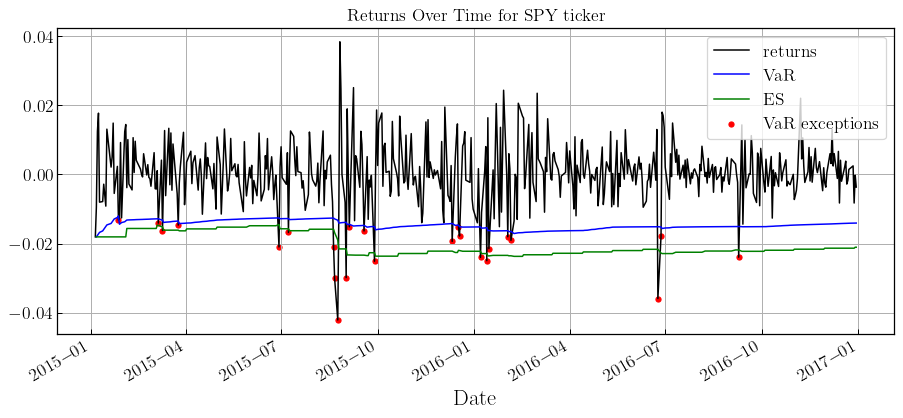

In [8]:
def get_metric_historical(pdReturns, alpha=0.95, verbose=False):
    """
    Compute Historical Value at Risk (VaR) and Expected Shortfall (ES) using an expanding window.

    Parameters
    ----------
    pdReturns : pd.Series
        Series of asset returns.
    alpha : float, optional
        Confidence level for VaR/ES calculation (default is 0.95 for 95% confidence).
    verbose : bool, optional
        If True, print the last VaR and ES values (default is False).

    Returns
    -------
    VaR : np.ndarray
        Array of historical VaR values. Initial values are NaN until at least one observation exists.
    ES : np.ndarray
        Array of historical Expected Shortfall values. Initial values are NaN until at least one observation exists.
    """
    returns = pdReturns.values
    n = len(returns)
    q = 100 * (1 - alpha)
    VaR = np.full(n, np.nan)
    ES = np.full(n, np.nan)

    for t in range(1, n):
        window_returns = returns[:t]
        var_t = np.percentile(window_returns, q)
        es_t = window_returns[window_returns <= var_t].mean()
        VaR[t] = var_t
        ES[t] = es_t

    if verbose:
        print(f"1-day {int(alpha*100)}% Historical VaR (last): {-VaR[-1]:.2%}")
        print(f"1-day {int(alpha*100)}% Historical ES (last): {-ES[-1]:.2%}")

    return VaR, ES

df['var_hist'], df['es_hist'] = get_metric_historical(df['returns'], verbose=True)
df['returns'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', figsize=(12, 5))
df['var_hist'].plot(label='VaR', c='b')
df['es_hist'].plot(label='ES', c='g')
mask = df['returns'] < df['var_hist']
plt.scatter(df.index[mask], df['returns'][mask], c='r', label='VaR exceptions')
plt.legend()

## 3.2 Monte-Carlo simulation
* Generates synthetic returns from a distribution (normal or t-dist), and the computes quantile.

* `Limitation:` Estimation depends on the distribution used to generate synthetic returns.

1-day 95% MC VaR: 1.37%
1-day 95% MC ES: 2.00%


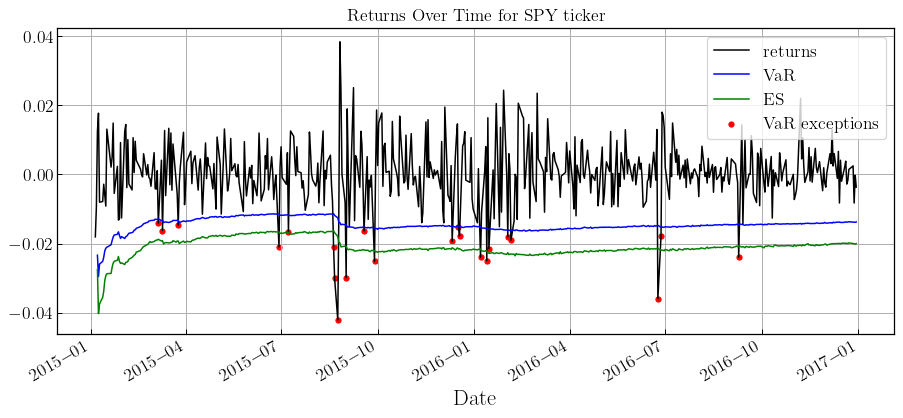

In [9]:
def get_metric_mc(returns, n_sim=100_000, alpha=0.95, nu=5, seed=42, verbose=False):
    """
    Compute Monte Carlo (Student-t) Value at Risk (VaR) and Expected Shortfall (ES) using an expanding window.

    Parameters
    ----------
    returns : np.ndarray or pd.Series
        Series or array of asset returns (positive for gains, negative for losses).
    n_sim : int, optional
        Number of Monte Carlo simulations (default is 100,000).
    alpha : float, optional
        Confidence level for VaR/ES calculation (default is 0.95 for 95% confidence).
    nu : float, optional
        Degrees of freedom for the Student-t distribution (default is 5).
    seed : int, optional
        Random seed for reproducibility (default is 42).
    verbose : bool, optional
        If True, print the last VaR and ES values (default is False).

    Returns
    -------
    VaR : np.ndarray
        Array of Monte Carlo VaR values. Initial values are NaN until `min_obs` is reached.
    ES : np.ndarray
        Array of Monte Carlo Expected Shortfall values. Initial values are NaN until `min_obs` is reached.
    """
    np.random.seed(seed)
    returns = np.array(returns)
    n = len(returns)

    VaR = np.full(n, np.nan)
    ES = np.full(n, np.nan)

    for t in range(2, n):
        past_returns = returns[:t]
        mu = np.mean(past_returns)
        sigma = np.std(past_returns, ddof=1)
        sigma_scaled = sigma / np.sqrt(nu / (nu - 2))
        returns_mc = mu + sigma_scaled * np.random.standard_t(nu, size=n_sim)
        VaR[t] = np.percentile(returns_mc, 100*(1-alpha))
        ES[t] = np.mean(returns_mc[returns_mc <= np.percentile(returns_mc, 100*(1-alpha))])

    if verbose:
        print(f"1-day {int(alpha*100)}% MC VaR: {-VaR[-1]:.2%}")
        print(f"1-day {int(alpha*100)}% MC ES: {-ES[-1]:.2%}")

    return VaR, ES

df['var_mc'], df['es_mc'] = get_metric_mc(df['returns'], verbose=True)
df['returns'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', figsize=(12, 5))
df['var_mc'].plot(label='VaR', c='b')
df['es_mc'].plot(label='ES', c='g')
mask = df['returns'] < df['var_mc']
plt.scatter(df.index[mask], df['returns'][mask], c='r', label='VaR exceptions')
plt.legend()

## 3.3 Time varying volatility: GARCH (1,1) model

A starting simple assumption is that the volatility is constant over time, which is not realistic. Mostly, the large or small volatility changes is followed by other large or small changes -- a core stylized fact of financial market.

`Limitation:` Requires volatility clustering

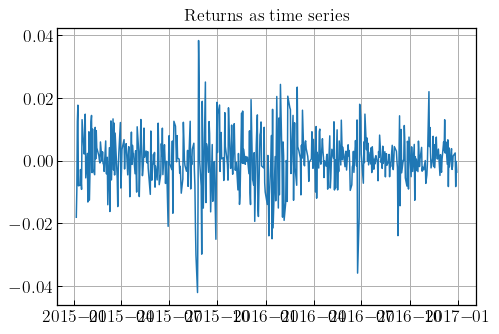

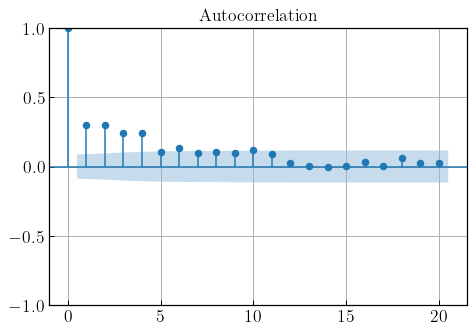

In [10]:
plt.plot(df['returns'])
plt.title('Returns as time series')
plot_acf(df['returns']**2, lags=20);

Here, ACF plot of returns measure the correlation between present value and its past lags. A significant lag 1 indicates that the GARCH(1,1) model can be used to model volatility. The GARCH model forecasts the present value using past value and shocks. Although the number of past components can be generalized to $p$ and $q$, we take $p=q=1$ since ACF drops significantly after lag 1. 

We compute 1-day ahead volatility using GARCH dynamics
$$
\sigma^2_{t+1} = \omega + \alpha\epsilon^2_{t} + \beta\sigma^2_{t}.
$$
Then the price follows
$$
r_{t+1} = \mu + \epsilon_{t+1}\; \text{with} \quad \epsilon_{t+1}=\sigma_{t+1} z_{t+1}.
$$
Here, parameters like ($\omega,\alpha,\beta,\mu,\sigma_{t+1}$) can be obtained from GARCH fit and $z_t \sim$ i.i.d. This enables us to generate synthetic Monte Carlo returns $r_t$ to compute VaR and ES.

1-day 95% GARCH VaR: 0.90%
1-day 95% GARCH ES: 1.27%


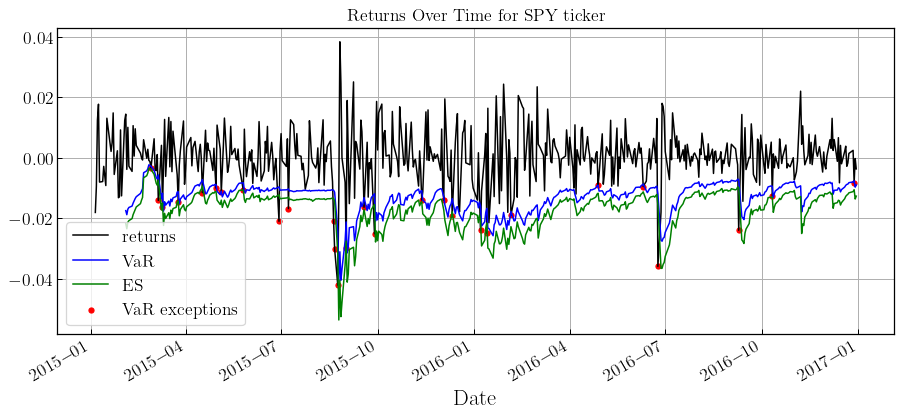

In [11]:
def get_metric_garch(
    pdReturns,
    scale=100,
    min_obs=20,
    alpha=0.95,
    n_sim=50_000,
    verbose=False
):
    """
    Computes 1-day-ahead VaR and ES using a GARCH(1,1) model
    with Student-t Monte Carlo simulation and an expanding window.

    Parameters
    ----------
    pdReturns : pd.Series
        Series of asset returns.
    scale : float, optional
        Scaling factor for returns (default is 100, for percentages).
    min_obs : int, optional
        Minimum number of past returns to fit GARCH model (default is 20).
    alpha : float, optional
        Confidence level for VaR/ES (default is 0.95).
    n_sim : int, optional
        Number of Monte Carlo simulations per step (default is 100,000).
    verbose : bool, optional
        If True, prints last VaR and ES (default is False).

    Returns
    -------
    VaR : np.ndarray
        Array of 1-day-ahead GARCH VaR estimates (positive numbers for losses).
    ES : np.ndarray
        Array of 1-day-ahead GARCH ES estimates (positive numbers for losses).

    """
    returns = scale * pdReturns.values
    n = len(returns)
    VaR = np.full(n, np.nan)
    ES = np.full(n, np.nan)

    for t in range(min_obs, n):
        window_returns = returns[:t]

        model = arch_model(
            window_returns,
            mean='Constant',
            vol='GARCH',
            p=1,
            q=1,
            dist='t'
        )
        res = model.fit(disp="off")

        mu = res.params['mu']
        omega = res.params['omega']
        alpha_g = res.params['alpha[1]']
        beta_g = res.params['beta[1]']
        nu = res.params['nu']

        sigma_t = res.conditional_volatility[-1]
        eps_t = window_returns[-1] - mu

        # 1-step-ahead forecast
        sigma_t1 = np.sqrt(omega + alpha_g * eps_t**2 + beta_g * sigma_t**2)

        # Monte Carlo simulation
        z = np.random.standard_t(nu, size=n_sim)
        z = z / np.sqrt(nu / (nu - 2))  # standardize to unit variance
        sim_returns = mu + sigma_t1 * z

        # Compute VaR and ES, internally positive for losses
        var_t = np.percentile(sim_returns, 100 * (1 - alpha))
        tail = sim_returns[sim_returns <= np.percentile(sim_returns, 100 * (1 - alpha))]
        es_t = tail.mean() if len(tail) > 0 else np.nan

        VaR[t] = var_t / scale
        ES[t] = es_t / scale

    if verbose:
        print(f"1-day {int(alpha*100)}% GARCH VaR: {-VaR[-1]:.2%}")
        print(f"1-day {int(alpha*100)}% GARCH ES: {-ES[-1]:.2%}")

    return VaR, ES

    
df['var_garch'], df['es_garch'] = get_metric_garch(df['returns'], verbose=True)
df['returns'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', figsize=(12, 5))
df['var_garch'].plot(label='VaR', c='b')
df['es_garch'].plot(label='ES', c='g')
mask = df['returns'] < df['var_garch']
plt.scatter(df.index[mask], df['returns'][mask], c='r', label='VaR exceptions')
plt.legend()

# 4. Stress Testing
Up until now, we have estimated VaR and ES under normal (calm) market conditions. However, it is important to gauge how a stressed market affect our estimations. Possible stressed scenarios can be downturn in revenue or volatility spikes. This also tells us how well metrics of calm markets capture the stressed situations.

In [12]:
def add_stress_test(df, return_shock=-0.10, vol_spike=2.0):
    """
    Add stressed Monte Carlo VaR and ES to main df
    Parameters:
        df : pd.DataFrame with 'returns'
        return_shock : float, e.g., -0.10 for 10% down
        vol_spike : float, e.g., 2.0 for doubling volatility
        confidence : float
    Returns:
        df with 'var_mc_stress' and 'es_mc_stress' columns
    """
    # Apply return shock and volatility spike
    stressed_returns = df['returns'] + return_shock  # shift down
    mu = stressed_returns.mean()
    stressed_returns = mu + (stressed_returns - mu) * vol_spike  # scale deviations
    # Compute Monte Carlo VaR and ES
    var_stress, es_stress = get_metric_mc(stressed_returns)
    # Add to main df
    df['returns_stress'] = stressed_returns
    df['var_mc_stress'] = var_stress
    df['es_mc_stress'] = es_stress

add_stress_test(df)

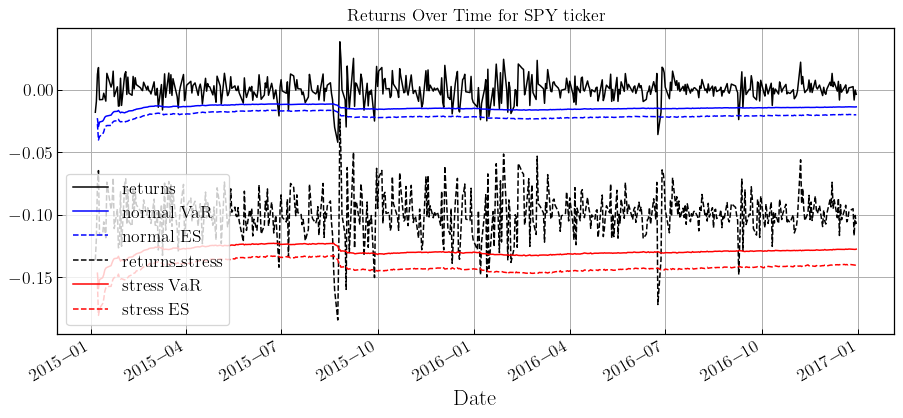

In [13]:
df['returns'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', figsize=(12, 5))
df['var_mc'].plot(label='normal VaR', c='b')
df['es_mc'].plot(label='normal ES', c='b', ls='--')

df['returns_stress'].plot(title=f'Returns Over Time for {myTicker} ticker', c='k', ls='--', figsize=(12, 5))
df['var_mc_stress'].plot(label='stress VaR', c='r')
df['es_mc_stress'].plot(label='stress ES', c='r', ls='--')
plt.legend()

In [14]:
print(f"Last day normal ES: {-df['es_mc'].iloc[-1]:.2%}, Last day stress ES: {-df['es_mc_stress'].iloc[-1]:.2%}")

Last day normal ES: 2.00%, Last day stress ES: 14.03%


`Interpretation`: We see ES sees a jump of 7x -- this shows severity of stress conditions, which is typically not reflected by normal metrics.

# 5. Backtesting
Now that we have a forecast, we want test its validity by backtesting with historical data. For this, we take 3y of data that is not included in previous estimations.

## 5.1 Kupiec Test 
To validate VaR forecast, we look at Kupiec test to check whether number of exceptions matches the expected probability. Particularly, the test statistic is
$$
LR = - 2 \ln \Big[\frac{(1-p)^{T-N}p^N}{(1-\hat{p})^{T-N}\hat{p}^N} \Big] \sim \chi^2(1),
$$
where 
* p = VaR
* N = no. of exceptions
* T = total observations
* $\hat{p}$ = N/T

In [15]:
def kupiec_test(pdReturns, pdVaR, alpha=0.95, verbose=True):
    """
    Performs Kupiec Proportion of Failures (POF) test.

    Args:
        pdReturns (pd.Series): Series of realized returns.
        pdVaR (pd.Series): Corresponding VaR forecasts.
        alpha (float): Confidence level.
        verbose (bool): If True, prints test results.

    Returns:
        dict: Kupiec test statistics and p-value.
    """
    returns = pdReturns.values
    VaR = pdVaR.values

    valid = ~np.isnan(VaR)
    returns = returns[valid]
    VaR = VaR[valid]

    exceptions = returns < VaR
    n = len(returns)
    x = exceptions.sum()
    p = 1 - alpha

    if x == 0:
        lr_stat = 0.0
        p_value = 1.0
    else:
        lr_stat = -2 * (
            x * np.log(p / (x / n)) +
            (n - x) * np.log((1 - p) / (1 - x / n))
        )
        p_value = 1 - chi2.cdf(lr_stat, df=1)

    if verbose:
        print(f"Observations: {n}")
        print(f"Exceptions: {x}")
        print(f"Expected exception: {p:.2%}")
        print(f"Observed exception: {x/n:.2%}")
        print(f"Kupiec p-value: {p_value:.4f}")

    # return {
    #     "n_obs": n,
    #     "n_exceptions": x,
    #     "observed_rate": x / n,
    #     "lr_stat": lr_stat,
    #     "p_value": p_value
    # }

In [16]:
print("-----------Parametric method------------") 
kupiec_test(df['returns'], df['var_param'])

print("------------Historical method------------") 
kupiec_test(df['returns'], df['var_hist'])

print("------------Monte-Carlo method------------") 
kupiec_test(df['returns'], df['var_mc'])

print("------------GARCH method------------") 
kupiec_test(df['returns'], df['var_garch'])

-----------Parametric method------------
Observations: 501
Exceptions: 20
Expected exception: 5.00%
Observed exception: 3.99%
Kupiec p-value: 0.2840
------------Historical method------------
Observations: 502
Exceptions: 24
Expected exception: 5.00%
Observed exception: 4.78%
Kupiec p-value: 0.8205
------------Monte-Carlo method------------
Observations: 501
Exceptions: 22
Expected exception: 5.00%
Observed exception: 4.39%
Kupiec p-value: 0.5235
------------GARCH method------------
Observations: 483
Exceptions: 28
Expected exception: 5.00%
Observed exception: 5.80%
Kupiec p-value: 0.4326


```Interpretation```: All methods have kupiec's p-value well above 0.05, meaning they are statistically acceptable. Observed exceptions are generally close to the expected 5%, with GARCH slightly over, and Monte Carlo slightly under.

## 4.2 Christoffersen test
Christoffersen test checks independence of VaR exceptions, that is, whether exceptions tend to cluster. This can be a probe for volatility clsutering. The test statistics has two parts:

#### Unconditional Coverage Test: 
Checks if the observed frequency of exceptions matches the expected frequency.
$$
LR_{uc} = -2[\ln L(\hat{\pi}) - \ln L(\hat{\pi}_0)],
$$
where
* $\hat{\pi}$ = (no. of exceptions / total observations)
* $\hat{\pi}_0$ = 1 - $\hat{\pi}$
* $L(.)$ is the likelihood function assuming Bernoulli trials.

#### Independence Test: 
First, we constructs a $2\times 2$ matrix for exceptions with the rule
* $n_{00}$: No exception → No exception
* $n_{01}$: No exception → Exception
* $n_{10}$: Exception → No exception
* $n_{11}$: Exception → Exception

Then the LR staistic is 
$$
LR_{ind} = -2[\ln L(\hat{\pi}) - \ln L(\hat{\pi}_{01}, \hat{\pi}_{11})]
$$

Under $H_0 :=$ The exceptions are (1-$\alpha$), we have $LR = LR_{uc}+ LR_{ind} \sim \chi(2)^2$

In [17]:
def christoffersen_test(pdReturns, pdVaR):
    """
    Perform Christoffersen test for independence of VaR exceptions.

    Parameters
    ----------
    pdReturns : pd.Series or np.ndarray
        Series or array of realized returns.
    pdVaR : pd.Series or np.ndarray
        Series or array of corresponding VaR estimates at the same confidence level.

    Returns
    -------
    LR_ind : float
        Christoffersen likelihood ratio statistic for independence of exceptions.
    p_value : float
        p-value of the test. Null hypothesis: VaR exceptions are independent.

    Notes
    -----
    - An exception is defined as a day where the realized return is less than the VaR.
    - The test examines the sequence of exceptions for clustering (autocorrelation).
    - LR_ind follows a chi-squared distribution with 1 degree of freedom.
    """
    returns = np.array(pdReturns)
    var = np.array(pdVaR)

    # Identify exceptions
    exceptions = returns < var

    # Count 2-state transitions
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(exceptions)):
        if not exceptions[i-1] and not exceptions[i]:
            n00 += 1
        elif not exceptions[i-1] and exceptions[i]:
            n01 += 1
        elif exceptions[i-1] and not exceptions[i]:
            n10 += 1
        else:  # 1->1
            n11 += 1

    # Transition probabilities
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Log-likelihoods
    def log_likelihood(p, n1, n0):
        return n1 * np.log(p) + n0 * np.log(1 - p) if 0 < p < 1 else 0

    L_indep = log_likelihood(pi, n01 + n11, n00 + n10)
    L_unres = log_likelihood(pi0, n01, n00) + log_likelihood(pi1, n11, n10)

    # Likelihood ratio statistic
    LR_ind = -2 * (L_indep - L_unres)
    p_value = 1 - chi2.cdf(LR_ind, 1)
    print(f"Christoffersen statistic: {LR_ind:.4f}, p-value: {p_value:.4f}")
    return LR_ind, p_value

print("-----------Parametric method------------") 
christoffersen_test(df['returns'], df['var_param']);

print("------------Historical method------------") 
christoffersen_test(df['returns'], df['var_hist']);

print("------------Monte-Carlo method------------") 
christoffersen_test(df['returns'], df['var_mc']);

print("------------GARCH method------------") 
christoffersen_test(df['returns'], df['var_garch']);

-----------Parametric method------------
Christoffersen statistic: 4.0847, p-value: 0.0433
------------Historical method------------
Christoffersen statistic: 5.0467, p-value: 0.0247
------------Monte-Carlo method------------
Christoffersen statistic: 6.2525, p-value: 0.0124
------------GARCH method------------
Christoffersen statistic: 0.1279, p-value: 0.7206


`Interpretation`: 
* Parametric - VaR exceptions are slightly clustered. Likley because the model sometimes underestimates risk in consecutive periods.
* Historical - We see stronger evidence of clustering than parametric model.
* Monte-Carlo - Most significant clustering among the first three methods. Student-t MC VaR occasionally underestimates tail risk during volatile clusters.
* GARCH - Significant p-value suggest it sucessfully accounts for volatility clustering, which produces independet exceptions. Well commensurate with the purpose of GARCH models i.e. capturing conditional heteroskedasticity.

# 6. Summary

In short, we compute the VaR and ES of the SPY ETF (obtained from Yahoo Finance) using various methods, including parametric, historical, Monte Carlo, and GARCH models. For the estimation of risk metrics, we use an expanding window approach, where the VaR at the present time is computed using all past values. This approach is useful for capturing long-term structure and is superior to static VaR estimates. However, it is less sensitive to changes in volatility, and old shocks continue to dominate the forecast. A rolling window could mitigate this issue, but it is beyond the scope of this study.

We perform backtesting on all four methods. The Kupiec test reveals that all methods match the expected VaR exception rate, which is 5% for a 95% confidence level. In particular, the historical method is the most accurate in this regard, while the Monte Carlo and GARCH methods slightly underestimate and overestimate the VaR, respectively. In contrast, the Christoffersen test shows that only the GARCH model accounts for volatility clustering, while the other models fail to account for the independence of exceptions. This means that in the event of a market shock, the VaR calculated from these three methods is likely to underestimate risk.

For future, interesting extensions can be comparing expanding vs. rolling window method, using multi-horizon VaR, or an ensemble approach for computing VaR.